In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

In [7]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def read_timeseries(metric, label, dirname):
    args  = {'skiprows' : 13, 'names': ["index", "Time (sec)", label]}
    fname = dirname + '/' + metric + '.wsp.out'
    try:
        df = pd.read_csv(fname, **args)
    except:
        sys.exit("Create time series (" + fname + ") does not exist, "+
                 "please cd to experiments/baseline-compile/visualize and run ./plot.sh")    
    del df['index']
    df = df[df['Time (sec)'] != 0]
    return df

results-cloudlab-clients1-procs32-log-sweep
results-cloudlab-clients1-procs16-log-sweep
results-cloudlab-clients1-procs8-log-sweep
results-cloudlab-clients1-procs4-log-sweep
results-cloudlab-clients1-procs2-log-sweep


(0, 1000)

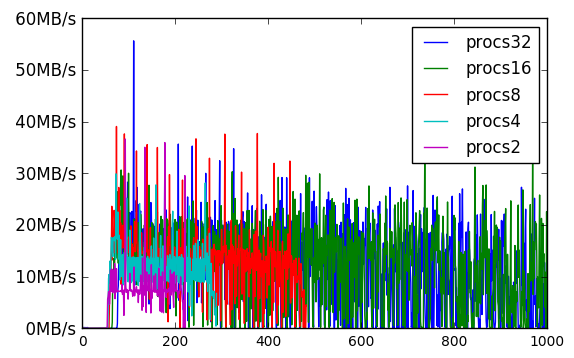

In [24]:
fig, ax = plt.subplots(1, 1)
def network(ax, dirname):
    df = read_timeseries('kbout-eth0', 'kbout_eth0', dirname)
    for i in ['1', '2', '3']:
        df = pd.merge(df, read_timeseries('kbout-eth'+i, 'kbout_eth'+i, dirname), on='Time (sec)')
        
    run = os.path.basename(dirname).split('-')[3]
    df[run] = df['kbout_eth0'] + df['kbout_eth1'] + df['kbout_eth2'] + df['kbout_eth3']
    df.plot(ax=ax, y=[run], label='test')
    print os.path.basename(dirname)
    ax.set_yticklabels(['{:3.0f}MB/s'.format(y/1000) for y in ax.get_yticks()], fontsize=12)

network(ax, '../results-cloudlab-clients1-procs32-log-sweep')    
network(ax, '../results-cloudlab-clients1-procs16-log-sweep')    
network(ax, '../results-cloudlab-clients1-procs8-log-sweep')
network(ax, '../results-cloudlab-clients1-procs4-log-sweep')
network(ax, '../results-cloudlab-clients1-procs2-log-sweep')
ax.set_xlim(0, 1000)

In [53]:
def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['results'][0]['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            r.append(to_seconds(end) - to_seconds(start))
    return r

def parse_runs(clients):
    mean = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    maxs = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    stds = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    for i in clients:
        j0 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "/*interfere*"))
        j1 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "/*isolated*"))    
        j2 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "-nolog/*interfere*"))
        j3 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "-nolog/*isolated*"))
        mean.loc[len(mean)] = [np.mean(j0), np.mean(j1), np.mean(j2), np.mean(j3)]
        maxs.loc[len(maxs)] = [np.max(j0), np.max(j1), np.max(j2), np.max(j3)]
        stds.loc[len(stds)] = [np.std(j0), np.std(j1), np.std(j2), np.std(j3)]
    return mean, stds, maxs

,isolated
0,0.0
1,0.0
2,0.0
3,0.0


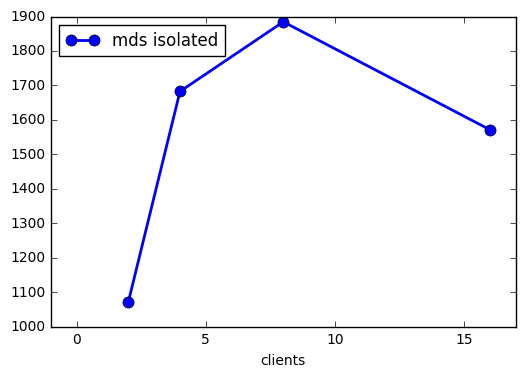

In [100]:
clients = [2, 4, 8, 16]
columns = ['isolated']
mean = pd.DataFrame(columns=columns)
stds = pd.DataFrame(columns=columns)
for i in clients:
    j0 = parse_mdtest(glob.glob("../results-cloudlab-clients1-procs"+str(i)+"-log-sweep/*isolated*"))
    mean.loc[len(mean)] = [np.max(j0)]
    stds.loc[len(stds)] = [np.std(j0)]

cols_mds = []
for col in columns:
    mean['mds ' + col] = [c*98000 for c in clients]/mean[col]
    cols_mds.append('mds ' + col)

fig, ax = plt.subplots(1, 1)
mean['clients'] = clientsvim 
mean[cols_mds].plot(x=mean['clients'], yerr=stds, ax=ax, lw=2, marker='o', ms=8)#, color=['blue', '#a6dba0', '#92c5de', 'green'])
ax.set_xlim(-1, 17)
#ax.set_yscale('log')
#ax.set_ylim([10**2,10**4])
mean
stds